# Turbofan Engine RUL Prediction - Version 3

This notebook provides a clean and organized implementation for predicting the Remaining Useful Life (RUL) of turbofan engines using a Recurrent Neural Network (RNN) model. The data consists of multivariate time series from multiple engines, with the goal of predicting the time to failure for each engine.

---

In [1]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random

# Load and Prepare Data

This section loads the turbofan engine data from multiple files, fills any missing values with zeros, and normalizes the sensor measurements using mean and standard deviation. It also computes the time to failure for each engine unit and ensures no NaN values remain after normalization.

In [2]:
train_file_names = [
    "turbofan_data/train_FD001.txt",
    "turbofan_data/train_FD002.txt",
    "turbofan_data/train_FD003.txt",
    "turbofan_data/train_FD004.txt"
]

test_file_names = [
    "turbofan_data/test_FD001.txt",
    "turbofan_data/test_FD002.txt",
    "turbofan_data/test_FD003.txt",
    "turbofan_data/test_FD004.txt"
]

column_names = [
    "unit_number", "time_in_cycles", "operational_setting_1", "operational_setting_2", "operational_setting_3",
    "sensor_measurement_1", "sensor_measurement_2", "sensor_measurement_3", "sensor_measurement_4", "sensor_measurement_5",
    "sensor_measurement_6", "sensor_measurement_7", "sensor_measurement_8", "sensor_measurement_9", "sensor_measurement_10",
    "sensor_measurement_11", "sensor_measurement_12", "sensor_measurement_13", "sensor_measurement_14", "sensor_measurement_15",
    "sensor_measurement_16", "sensor_measurement_17", "sensor_measurement_18", "sensor_measurement_19", "sensor_measurement_20",
    "sensor_measurement_21", "sensor_measurement_22", "sensor_measurement_23", "sensor_measurement_24", "sensor_measurement_25",
    "sensor_measurement_26"
]

all_data = pd.concat(
    [pd.read_csv(file, sep="\s+", header=None, names=column_names) for file in train_file_names],
    ignore_index=True
)

test_data = pd.concat(
    [pd.read_csv(file, sep="\s+", header=None, names=column_names) for file in test_file_names],
    ignore_index=True
)

all_data_filled = all_data.fillna(0)
test_data_filled = test_data.fillna(0)

mean_values = all_data_filled.iloc[:, 5:].mean()
std_values = all_data_filled.iloc[:, 5:].std()

all_data_normalized = all_data_filled.copy()
all_data_normalized.iloc[:, 5:] = (all_data_filled.iloc[:, 5:] - mean_values) / std_values

test_data_normalized = test_data_filled.copy()
test_data_normalized.iloc[:, 5:] = (test_data_filled.iloc[:, 5:] - mean_values) / std_values

all_data_normalized['time_to_failure'] = all_data_normalized.groupby('unit_number')['time_in_cycles'].transform(lambda x: x.max() - x)
test_data_normalized['time_to_failure'] = test_data_normalized.groupby('unit_number')['time_in_cycles'].transform(lambda x: x.max() - x)

all_data_normalized.fillna(0, inplace=True)
test_data_normalized.fillna(0, inplace=True)

<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2440/311680387.py:26: SyntaxWarning: invalid escape sequence '\s'
  [pd.read_csv(file, sep="\s+", header=None, names=column_names) for file in train_file_names],
/tmp/ipykernel_2440/311680387.py:31: SyntaxWarning: invalid escape sequence '\s'
  [pd.read_csv(file, sep="\s+", header=None, names=column_names) for file in test_file_names],
/tmp/ipykernel_2440/311680387.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0         1.009019
1         1.009019
2         0.944547
3         1.009019
4         1.041254
            ...   
160354    0.364303
160355    1.137962
160356    1.105726
160357   -0.763949
160358   -0.892892
Name: sensor_measurement_17, Length: 160359, dtype: float64' has dtype incompat

# Define PyTorch Model for Time-to-Failure Prediction

This section defines a PyTorch model class `WTTEModel` for predicting the time-to-failure of turbofan engines. The model uses an LSTM layer to process the input sequence and a fully connected layer to output the Weibull distribution parameters, alpha and beta.

In [3]:
class WTTEModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=2):
        super(WTTEModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_lstm, _ = self.rnn(x)
        out = self.fc(h_lstm[:, -1, :])
        alpha = torch.exp(out[:, 0])
        beta = torch.sigmoid(out[:, 1]) * 5.0
        return alpha, beta

input_size = 26
hidden_size = 50
model = WTTEModel(input_size, hidden_size)

print(model)

WTTEModel(
  (rnn): LSTM(26, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)


# Define WTTE Loss Function

This section implements the WTTE (Weibull Time-To-Event) loss function, which calculates the log-likelihood of the observed data given the predicted Weibull parameters. The loss function is used to train the model to predict the time-to-failure accurately.

In [4]:
def wtte_loss(y_true, alpha, beta, epsilon=1e-6):
    y, u = y_true[:, 0], y_true[:, 1]
    ya = (y + epsilon) / alpha
    loglikelihoods = u * (torch.log(beta) + beta * torch.log(ya)) - torch.pow(ya, beta)
    return -torch.mean(loglikelihoods)

# Prepare Data for PyTorch

This section defines a custom dataset class `TurbofanDataset` for loading the turbofan engine data into PyTorch. It prepares the features and targets for training and testing, assuming all data points are uncensored. Data loaders are created for both training and test datasets.

In [5]:
class TurbofanDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.features = data.iloc[:, 5:-1].values
        self.targets = data[['time_to_failure']].values
        self.censoring = np.ones((len(data), 1))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        u = torch.tensor(self.censoring[idx], dtype=torch.float32)
        return x, torch.cat((y, u), dim=0)

train_dataset = TurbofanDataset(all_data_normalized)
test_dataset = TurbofanDataset(test_data_normalized)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training Loop with Loss Logging and Extended Epochs

This section implements the training loop for the WTTE model. It includes loss logging and runs for an extended number of epochs. The model is trained using the Adam optimizer, and both training and test losses are captured for each epoch.

In [6]:
def train_model(model, train_loader, test_loader, num_epochs=30, learning_rate=0.0001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        total_train_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            alpha, beta = model(x_batch.unsqueeze(1))
            loss = wtte_loss(y_batch, alpha, beta)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                alpha, beta = model(x_batch.unsqueeze(1))
                loss = wtte_loss(y_batch, alpha, beta)
                total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    return train_losses, test_losses

train_losses, test_losses = train_model(model, train_loader, test_loader, learning_rate=0.00001)

Epoch 1/30, Train Loss: 127991.0391, Test Loss: 4894.8882
Epoch 2/30, Train Loss: 1450.9759, Test Loss: 39.3253
Epoch 3/30, Train Loss: 12.3709, Test Loss: 3.0199
Epoch 4/30, Train Loss: 2.7331, Test Loss: 2.3706
Epoch 5/30, Train Loss: 2.1624, Test Loss: 1.8142
Epoch 6/30, Train Loss: 1.5524, Test Loss: 1.3076
Epoch 7/30, Train Loss: 1.1563, Test Loss: 1.2593
Epoch 8/30, Train Loss: 1.1014, Test Loss: 1.2802
Epoch 9/30, Train Loss: 1.0950, Test Loss: 1.2833
Epoch 10/30, Train Loss: 1.0903, Test Loss: 1.2818
Epoch 11/30, Train Loss: 1.0856, Test Loss: 1.2799
Epoch 12/30, Train Loss: 1.0812, Test Loss: 1.2812
Epoch 13/30, Train Loss: 1.0768, Test Loss: 1.2801
Epoch 14/30, Train Loss: 1.0725, Test Loss: 1.2793
Epoch 15/30, Train Loss: 1.0679, Test Loss: 1.2777
Epoch 16/30, Train Loss: 1.0630, Test Loss: 1.2792
Epoch 17/30, Train Loss: 1.0580, Test Loss: 1.2798
Epoch 18/30, Train Loss: 1.0529, Test Loss: 1.2803
Epoch 19/30, Train Loss: 1.0475, Test Loss: 1.2822
Epoch 20/30, Train Loss: 1.

# Enhanced Visualization for Training and Test Results

This section provides enhanced visualization for the model's predictions versus the actual targets for both training and test datasets. It calculates and displays the Mean Absolute Error (MAE) for each dataset, providing insight into the model's performance.

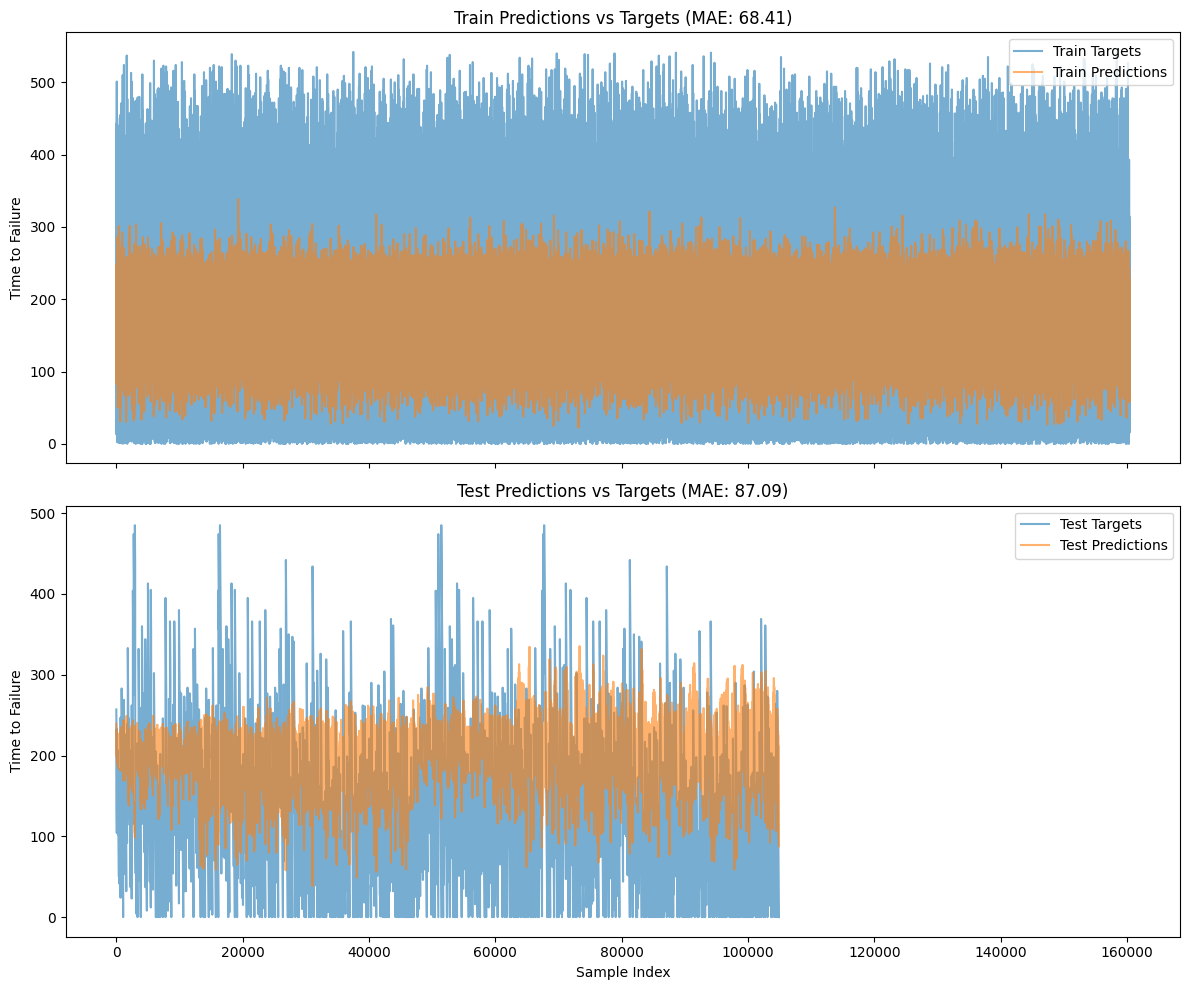

In [8]:
def plot_enhanced_results(train_loader, test_loader, model):
    model.eval()
    train_predictions, train_targets = [], []
    test_predictions, test_targets = [], []  # Corrected initialization

    with torch.no_grad():
        for x_batch, y_batch in train_loader:
            alpha, beta = model(x_batch.unsqueeze(1))
            train_predictions.extend(alpha.cpu().numpy())
            train_targets.extend(y_batch[:, 0].cpu().numpy())

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            alpha, beta = model(x_batch.unsqueeze(1))
            test_predictions.extend(alpha.cpu().numpy())
            test_targets.extend(y_batch[:, 0].cpu().numpy())

    train_mae = np.mean(np.abs(np.array(train_predictions) - np.array(train_targets)))
    test_mae = np.mean(np.abs(np.array(test_predictions) - np.array(test_targets)))

    fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    axs[0].plot(train_targets, label='Train Targets', alpha=0.6)
    axs[0].plot(train_predictions, label='Train Predictions', alpha=0.6)
    axs[0].set_title(f'Train Predictions vs Targets (MAE: {train_mae:.2f})')
    axs[0].set_ylabel('Time to Failure')
    axs[0].legend()

    axs[1].plot(test_targets, label='Test Targets', alpha=0.6)
    axs[1].plot(test_predictions, label='Test Predictions', alpha=0.6)
    axs[1].set_title(f'Test Predictions vs Targets (MAE: {test_mae:.2f})')
    axs[1].set_xlabel('Sample Index')
    axs[1].set_ylabel('Time to Failure')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_enhanced_results(train_loader, test_loader, model)

# Visualize Training and Test Losses Starting from a Specific Epoch

This section plots the training and test losses over the epochs, starting from a specified epoch. This visualization helps in understanding the model's learning progress and identifying any issues such as overfitting or underfitting.

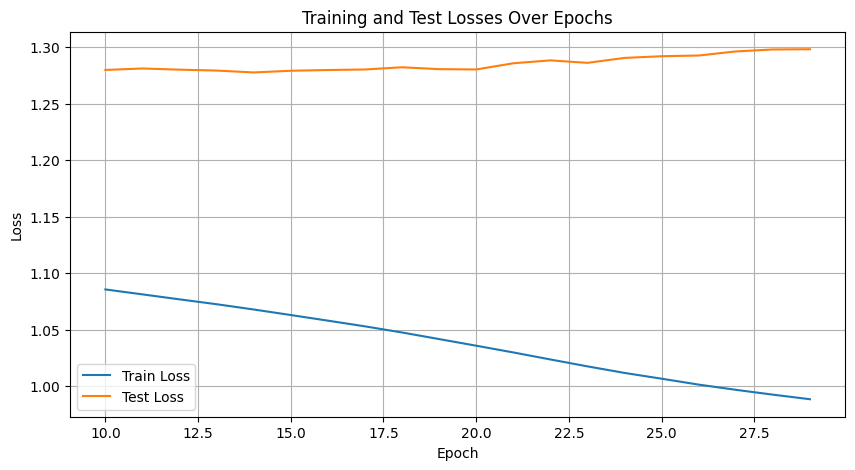

In [9]:
start_epoch = 10

def plot_losses(train_losses, test_losses, start_epoch=0):
    plt.figure(figsize=(10, 5))
    plt.plot(range(start_epoch, len(train_losses)), train_losses[start_epoch:], label='Train Loss')
    plt.plot(range(start_epoch, len(test_losses)), test_losses[start_epoch:], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Losses Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, test_losses, start_epoch=start_epoch)

# Plot Predicted Weibull Distribution for a Random Engine with Blue-to-Red Color-Coding

This section plots the predicted Weibull distribution for a randomly selected engine from the test set. It uses a blue-to-red color scheme to represent 16 evenly spaced steps, providing a visual progression of the engine's predicted time-to-failure distribution over time. A vertical red line indicates the true failure step.

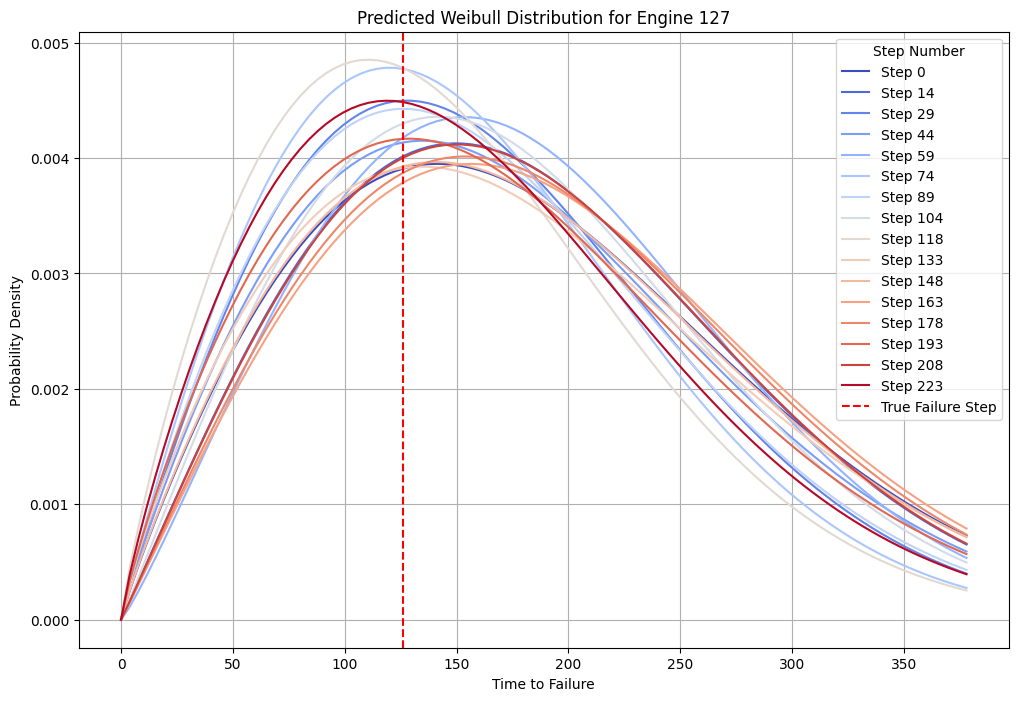

In [10]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import random

random_engine_id = random.choice(test_data_normalized['unit_number'].unique())
engine_data = test_data_normalized[test_data_normalized['unit_number'] == random_engine_id]

engine_dataset = TurbofanDataset(engine_data)
engine_loader = DataLoader(engine_dataset, batch_size=1, shuffle=False)

engine_lifespan = engine_data['time_in_cycles'].max()

plt.figure(figsize=(12, 8))
model.eval()
with torch.no_grad():
    num_lines = 16
    step_indices = np.linspace(0, len(engine_loader) - 1, num_lines, dtype=int)
    for i, (x, y) in enumerate(engine_loader):
        if i in step_indices:
            alpha, beta = model(x.unsqueeze(1))
            alpha, beta = alpha.item(), beta.item()
            x_values = np.linspace(0, 3 * engine_lifespan, 100)
            weibull_pdf = stats.weibull_min.pdf(x_values, c=beta, scale=alpha)
            color_intensity = i / len(engine_loader)
            plt.plot(x_values, weibull_pdf, label=f'Step {i}', color=plt.cm.coolwarm(color_intensity))

plt.axvline(x=engine_lifespan, color='red', linestyle='--', label='True Failure Step')

plt.title(f'Predicted Weibull Distribution for Engine {random_engine_id}')
plt.xlabel('Time to Failure')
plt.ylabel('Probability Density')
plt.legend(title='Step Number')
plt.grid(True)
plt.show()

# Additional Chart: Cumulative Distribution Function (CDF) for the Random Engine

This section plots the Cumulative Distribution Function (CDF) for the same 16 evenly spaced steps of the selected engine. The CDF provides insight into the cumulative probability of failure over time, with a color transition from blue to red as the step number increases.

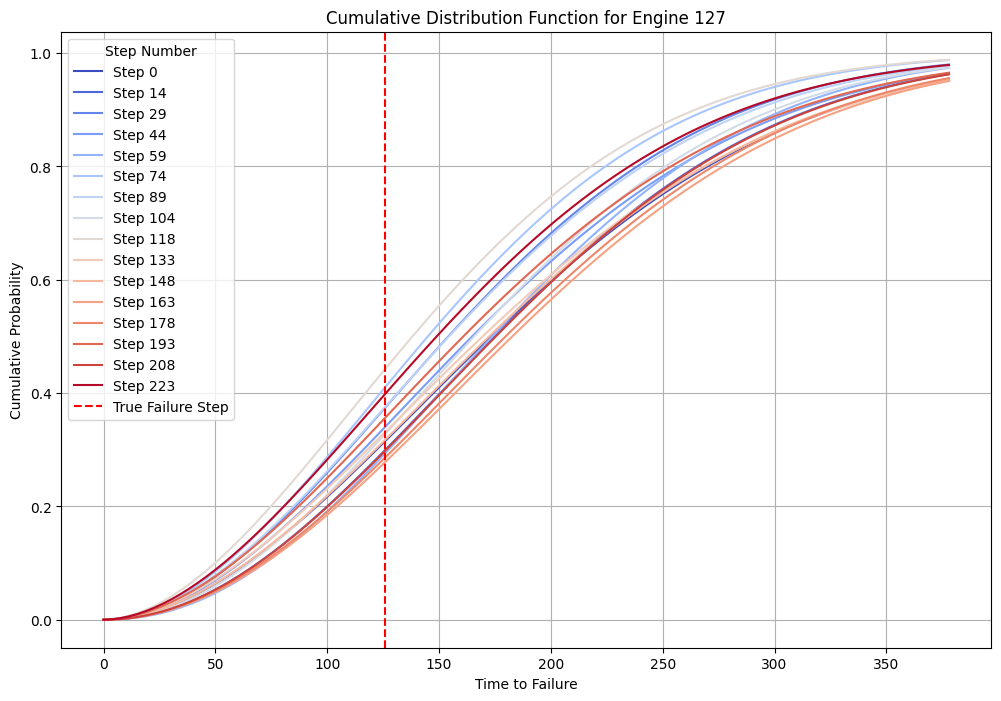

In [11]:
plt.figure(figsize=(12, 8))
model.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(engine_loader):
        if i in step_indices:
            alpha, beta = model(x.unsqueeze(1))
            alpha, beta = alpha.item(), beta.item()
            x_values = np.linspace(0, 3 * engine_lifespan, 100)
            weibull_cdf = stats.weibull_min.cdf(x_values, c=beta, scale=alpha)
            color_intensity = i / len(engine_loader)
            plt.plot(x_values, weibull_cdf, label=f'Step {i}', color=plt.cm.coolwarm(color_intensity))

plt.axvline(x=engine_lifespan, color='red', linestyle='--', label='True Failure Step')

plt.title(f'Cumulative Distribution Function for Engine {random_engine_id}')
plt.xlabel('Time to Failure')
plt.ylabel('Cumulative Probability')
plt.legend(title='Step Number')
plt.grid(True)
plt.show()